In [2]:
from losses.losses import TverskyLoss
from model.unet import getModel
import sun_dataset.sun_dataset

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

model = getModel()

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),
              loss=TverskyLoss(alpha=0.9835, smooth=2e4),
              metrics=['acc'])
model.load_weights('neuralnet/saved_weights')

suns= tfds.load('sun_dataset')
PICTURE_SIZE = 224

@tf.autograph.experimental.do_not_convert
def load_images(datapoint):
  input_image = tf.image.resize(datapoint['image'], (PICTURE_SIZE, PICTURE_SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (PICTURE_SIZE, PICTURE_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.math.round(tf.cast(input_mask, tf.float32) / 255.0)
  inverted_mask = tf.math.subtract(tf.ones((PICTURE_SIZE, PICTURE_SIZE, 1)), input_mask)

  return input_image, inverted_mask

def display(display_list):

  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

test = suns['test'].map(load_images).batch(1)

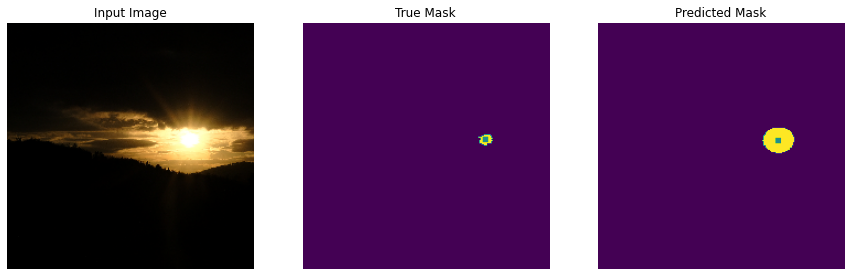

Differenz der Mittelpunkte:
[  0.4663228024930106 ,  -1.9875993982377054  ]


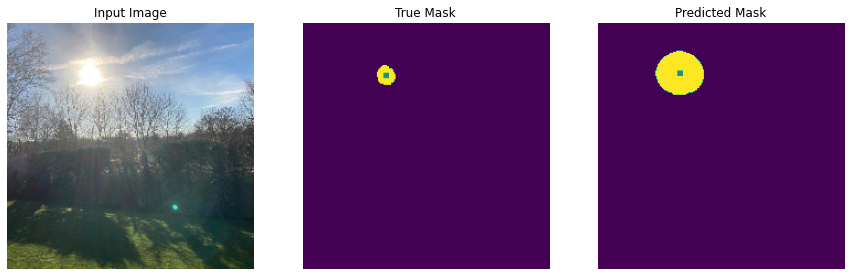

Differenz der Mittelpunkte:
[  -1.9737727857196887 ,  -0.9932304666817942  ]


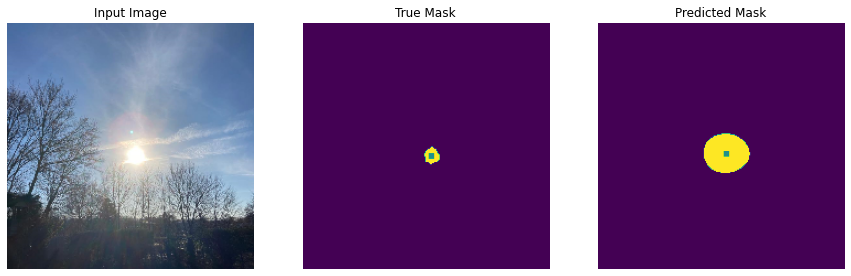

Differenz der Mittelpunkte:
[  -2.255178268251271 ,  -0.5950764006791189  ]


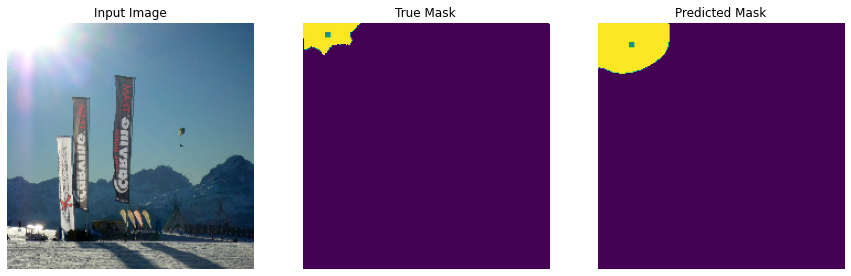

Differenz der Mittelpunkte:
[  9.632153614457831 ,  7.449673694779115  ]


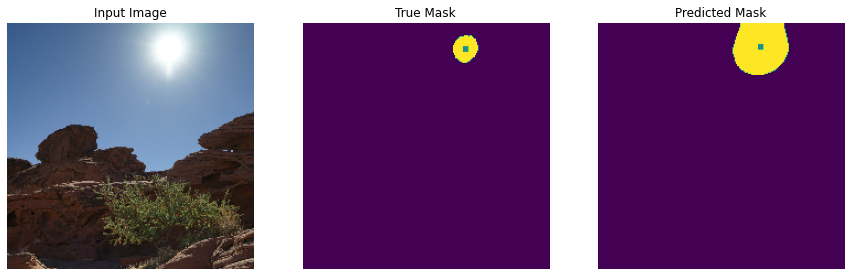

Differenz der Mittelpunkte:
[  -1.334554224876097 ,  0.18063992382712968  ]


In [3]:
#Mittelpunkt der markierten Sonnenfläche brechnen
def center_of_mass(array):                        #input shape of numpy array [batch, x, y, dimension]
    center_x, center_y, pixels = 0,0,0
    for x in range(224):
        for y in range(224):
            if array[0][x][y][0]>0.75:
                center_x += x
                center_y += y
                pixels += 1
    return (center_x/pixels, center_y/pixels) 

def mark_center(arr, center):
    for x in range(224):
        for y in range(224):
            if center[0]-3<x<center[0]+3 and center[1]-3<y<center[1]+3:
                arr[0][x][y][0]=0.5
    return arr
    
for image, mask in test.take(5):
    pred = model.predict(image)                          #output shape [batch, x, y, dimension]
    pred = np.round(pred)
    
    mask = mask.numpy()
    
    #Mittelpunkt markieren
    pred_center = center_of_mass(pred)
    pred = mark_center(pred, np.round(pred_center))
    
    true_center = center_of_mass(mask)
    mask = mark_center(mask, np.round(true_center))
    
    #Ausgabe
    display([image[0], mask[0], pred[0]])
    
    #Differenz der Mittelpunkte
    print("Differenz der Mittelpunkte:")
    print("[ ", pred_center[0] - true_center[0], ", ", pred_center[1] - true_center[1] ," ]")


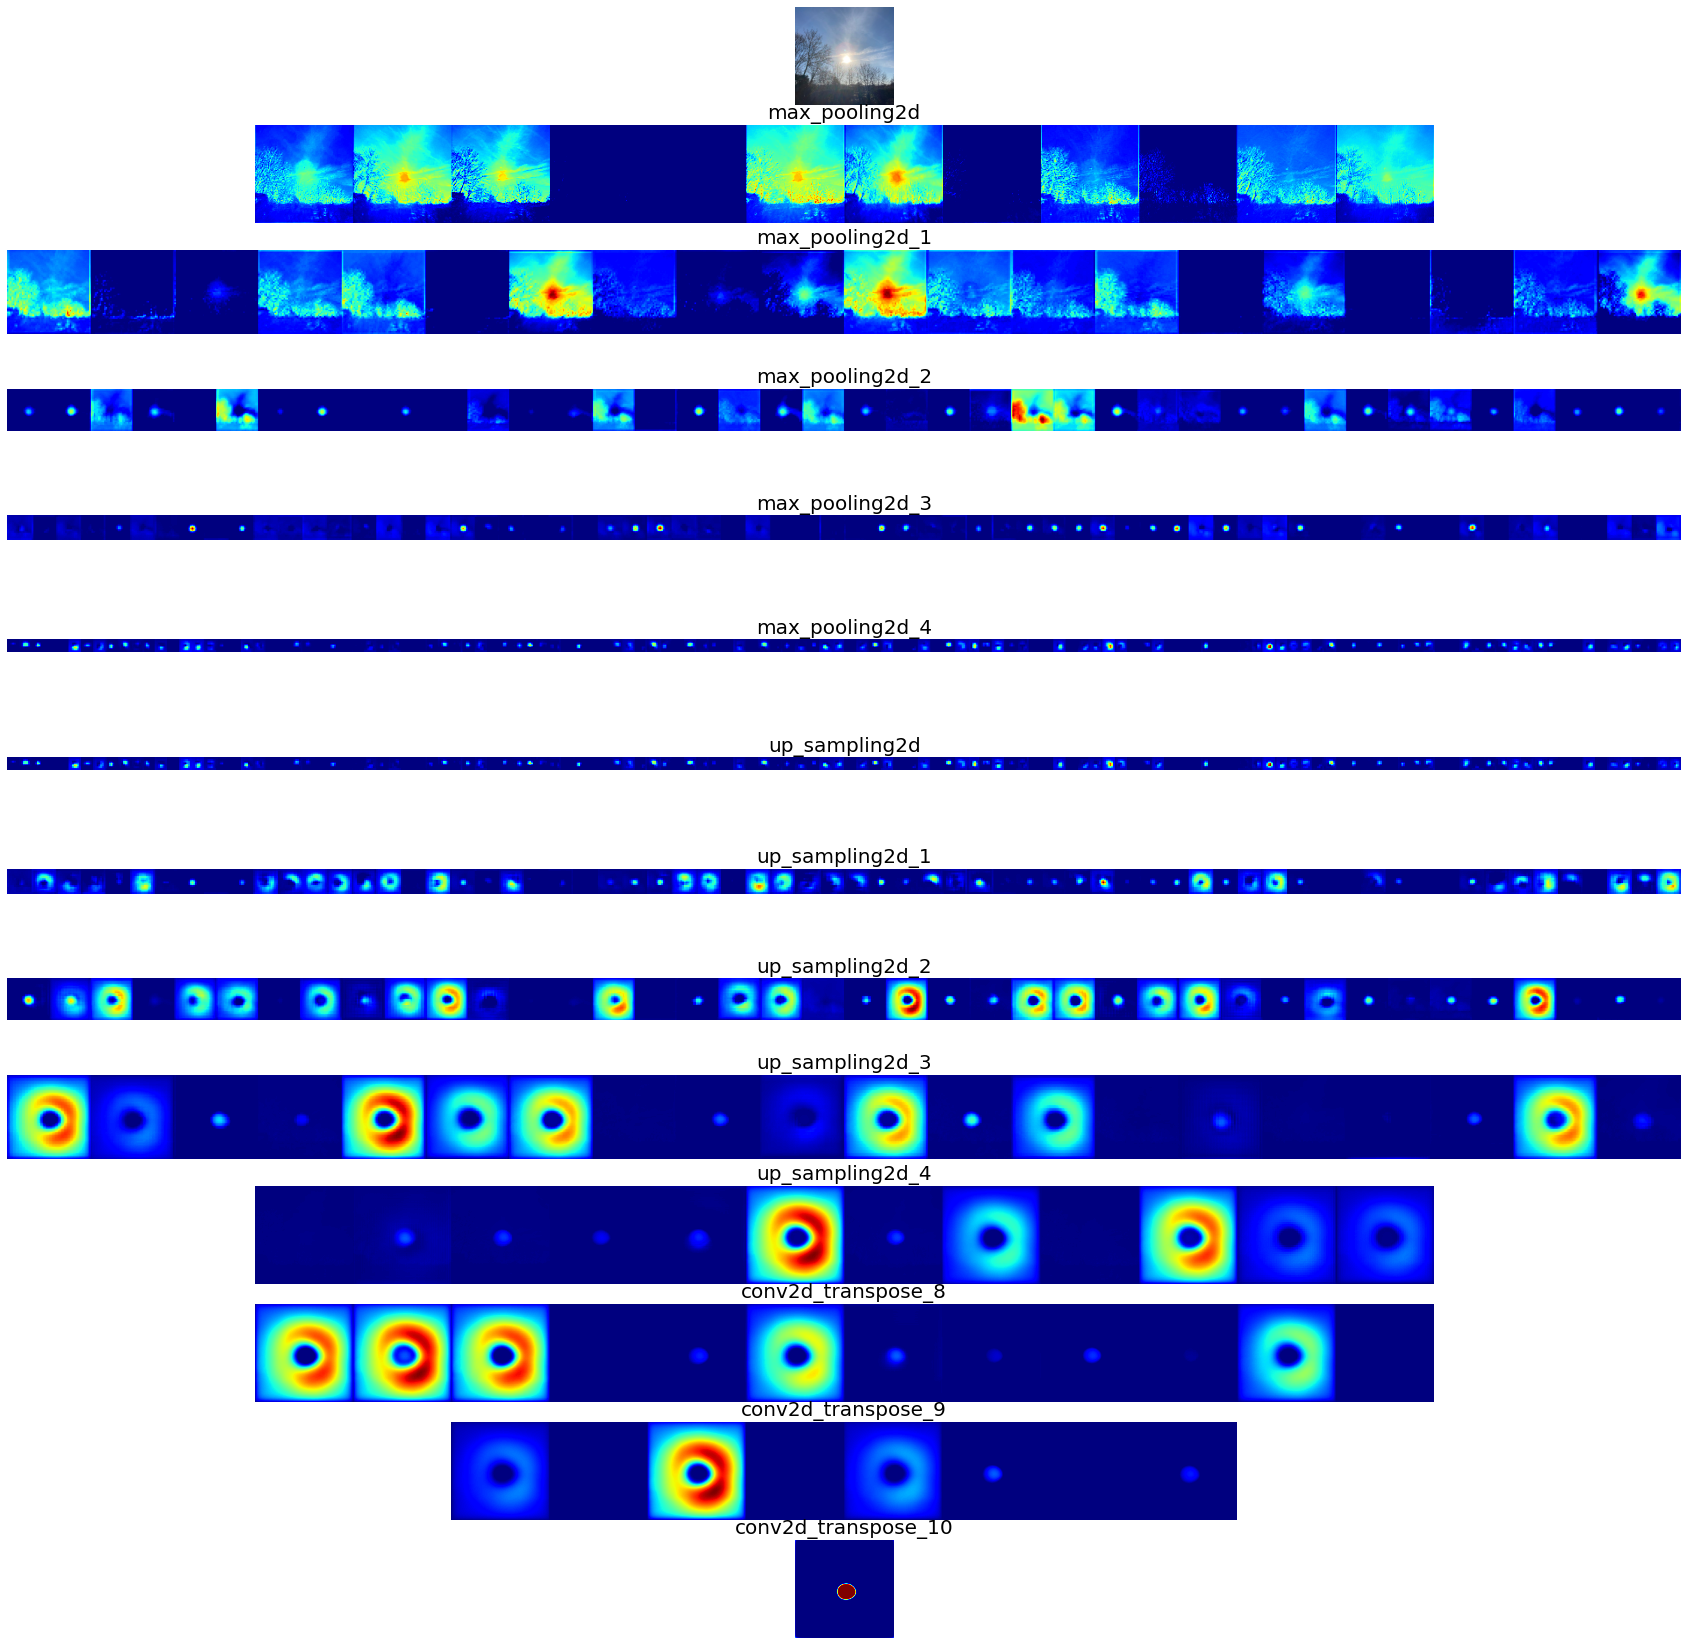

In [10]:
from tensorflow.keras.models import Model

#Methode von https://github.com/deeplearning-mit-tensorflow-keras-tfjs/2020_Zweite_Auflage
#um zu visualisieren, was die einzelnen Schichten (Layers) ausgeben
def visualize_layers_output(model,layer_names,input_image):
    
    feature_maps = []
    fig = plt.figure(figsize=(30,30))

    # Eingabebild wird dargestellt
    # Ggfs. für ein anderes Modell, 
    # muss dieser Block verändert werden
    ax = fig.add_subplot(len(layer_names)+1,1,1)
    ax.imshow(input_image[0],cmap=plt.gray())
    ax.set_axis_off()

    for i, layer_name in enumerate(layer_names):
        try:
            model.get_layer(layer_name)
        except ValueError as err:
            print("{} : Modell besitzt keinen Layer mit diesem Namen ".format(err))

        output_of_layer = model.get_layer(layer_name).output

        m = Model(inputs=model.input,outputs=output_of_layer)

        # Feature Map wird generiert

        feature_map = m(input_image)

        ax = fig.add_subplot(len(layer_names)+1,1,i+2)
        
        # Überprüfung
        if len(feature_map.shape) == 4: # Wenn 4 dann ist es ein Bild (1,28,28,3)
            feature_maps.append(np.hstack(np.transpose(feature_map[0], (2, 0, 1))))
        else: 
            if len(feature_map.shape) == 2: # Ein 1D-Array 
                feature_maps.append(np.expand_dims(feature_map[0],0))
            
        ax.imshow(feature_maps[i],cmap='jet')
        ax.set_title(layer_name, fontsize=20)
        ax.set_axis_off()
        del m
    
    plt.show()

#auszugebende Layers
layers = ["max_pooling2d", "max_pooling2d_1", "max_pooling2d_2", "max_pooling2d_3", "max_pooling2d_4","up_sampling2d", "up_sampling2d_1", "up_sampling2d_2", "up_sampling2d_3", "up_sampling2d_4", "conv2d_transpose_8", "conv2d_transpose_9", "conv2d_transpose_10"]

for image, mask in test.take(3):
    input_image = image

visualize_layers_output(model, layers, input_image.numpy())
